# TELCO CUSTOMER CHURN PREDICTION ANALYSIS

# 📘 Business Understanding

## 🎯 Objective
The goal of this project is to **predict whether a customer will churn (i.e., leave the telecom company)** using historical customer data. This enables the company to identify at-risk customers early and take action to retain them.

---

## 💼 Business Context
Customer churn is a major concern in subscription-based industries like telecommunications. It is **more cost-effective to retain existing customers than to acquire new ones**.

By analyzing customer data and predicting churn, telecom companies can:
- Understand why customers leave.
- Identify customers at risk of churning.
- Implement strategies to improve retention.

---

## ❓ Key Business Questions
- Which customers are likely to churn?
- What are the key factors driving customer churn?
- Can we predict churn early enough to take preventive action?
- What customer segments are more loyal, and why?

---

## 📊 Success Criteria
- Build a model with strong **predictive performance**, especially high **recall** (so we don’t miss likely churners).
- Provide **interpretable** results to guide business decisions.
- Generate **actionable insights** to inform retention strategies.

---

## 🏷️ Target Variable
- `Churn`: A binary variable indicating whether a customer has left the company (Yes/No).

---

## 📥 Input Features
- **Demographics**: Gender, SeniorCitizen, Partner, Dependents.
- **Account Information**: Tenure, Contract type, Paperless billing, Payment method.
- **Service Usage**: InternetService, StreamingTV, OnlineSecurity, etc.
- **Billing Info**: MonthlyCharges, TotalCharges.

---

## 🧠 Business Value
A successful churn prediction model allows the company to:
- **Reduce churn** by targeting interventions toward high-risk customers.
- **Improve customer retention** and satisfaction.
- **Increase profitability** by maximizing customer lifetime value (CLV).


In [27]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, mean_absolute_error, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import joblib

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

## **DATA UNDERSTANDING**

In [3]:
# Loading My Dataset and Creating a DataFrame

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Checking for Null Values

df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### - The column `TotalCharge` is an object but should be an integer as it contains numerical values

#### **Data Cleaning**

In [7]:
# Define wrangle function

def wrangle(df):

    # Convert "TotalCharges" from string to integer, Coerce errors to NaN
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

    # Dropping missing values in "TotalCharges" as "TotalCharges" = "tenure" * "MonthlyCharges" and All NaN values have a tenure of 0
    df.dropna(inplace=True)

    # Dropping "customerID" column as it has high cardinality and adds no value to determining "Churn"
    df.drop(columns=["customerID"], inplace=True)

    return df

In [8]:
# Wrangle Data

df = wrangle(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

In [9]:
# Summariy statistics for numeric columns

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [10]:
string_cols = pd.DataFrame({col: [df[col].nunique()] for col in df.select_dtypes(include='object')}).T.rename(columns={0: 'Unique Count'}).sort_values('Unique Count', ascending=False)
string_cols

,Unique Count
PaymentMethod,4
MultipleLines,3
InternetService,3
OnlineSecurity,3
OnlineBackup,3
DeviceProtection,3
TechSupport,3
StreamingTV,3
StreamingMovies,3
Contract,3


In [11]:
# Get all categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Loop through each and print unique values
for col in cat_cols:
    unique_vals = df[col].unique()
    print(f"{col} ➤ {list(unique_vals)}\n")


gender ➤ ['Female', 'Male']

Partner ➤ ['Yes', 'No']

Dependents ➤ ['No', 'Yes']

PhoneService ➤ ['No', 'Yes']

MultipleLines ➤ ['No phone service', 'No', 'Yes']

InternetService ➤ ['DSL', 'Fiber optic', 'No']

OnlineSecurity ➤ ['No', 'Yes', 'No internet service']

OnlineBackup ➤ ['Yes', 'No', 'No internet service']

DeviceProtection ➤ ['No', 'Yes', 'No internet service']

TechSupport ➤ ['No', 'Yes', 'No internet service']

StreamingTV ➤ ['No', 'Yes', 'No internet service']

StreamingMovies ➤ ['No', 'Yes', 'No internet service']

Contract ➤ ['Month-to-month', 'One year', 'Two year']

PaperlessBilling ➤ ['Yes', 'No']

PaymentMethod ➤ ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']

Churn ➤ ['No', 'Yes']



## **EXPLORATORY DATA ANALYSIS (EDA)**

#### **Customer Churn Count**

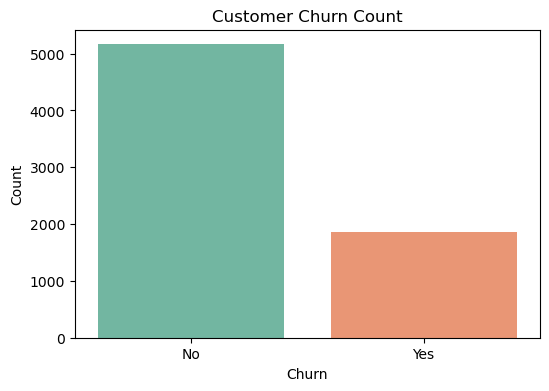

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title('Customer Churn Count')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show();

- class distribution of my target vector (y)  i.e., `Churn` is imbalanced

#### **Churn by Gender**

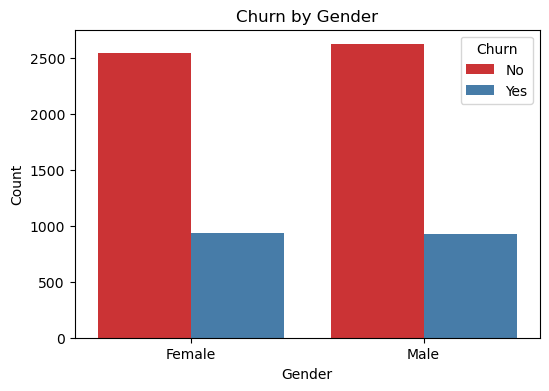

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender', hue='Churn', palette='Set1')
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.show();

#### **Churn by Contract Type**

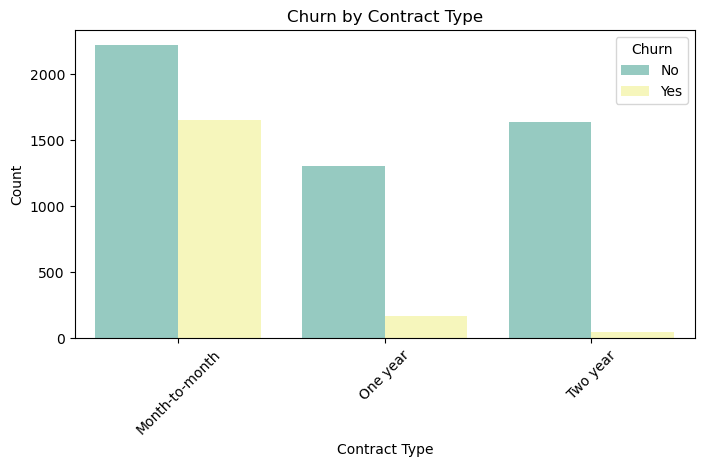

In [14]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Contract', hue='Churn', palette='Set3')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Churn')
plt.show();

#### **Tenure Distribution by Churn**

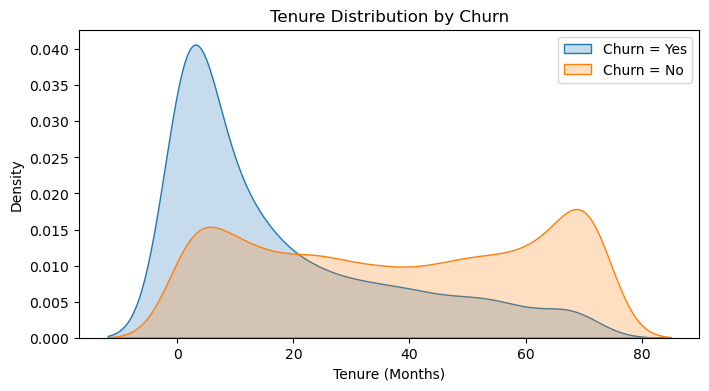

In [15]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data=df[df['Churn'] == 'Yes'], x='tenure', label='Churn = Yes', shade=True)
sns.kdeplot(data=df[df['Churn'] == 'No'], x='tenure', label='Churn = No', shade=True)
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')
plt.ylabel('Density')
plt.legend()
plt.show();

#### **Monthly Charges Distribution by Churn**

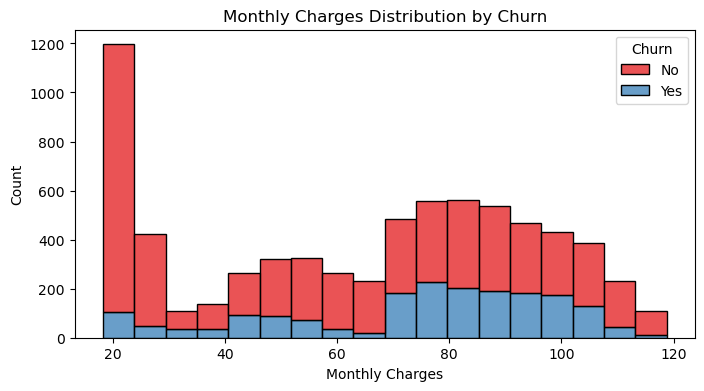

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', palette='Set1')
plt.title('Monthly Charges Distribution by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')
plt.show();

#### **Churn by Payment Method**

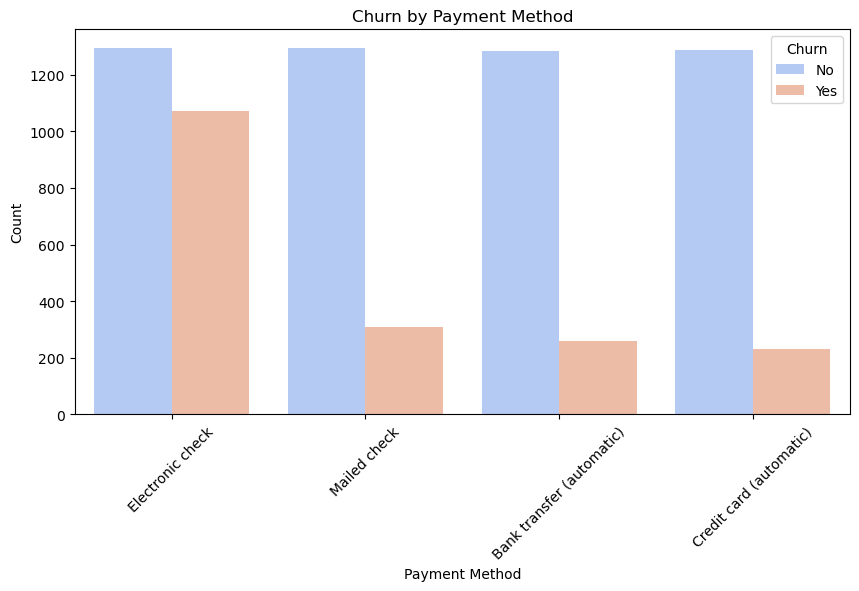

In [17]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='PaymentMethod', hue='Churn', palette='coolwarm')
plt.title('Churn by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Churn')
plt.show();

#### **Total Charges Distribution by Churn**

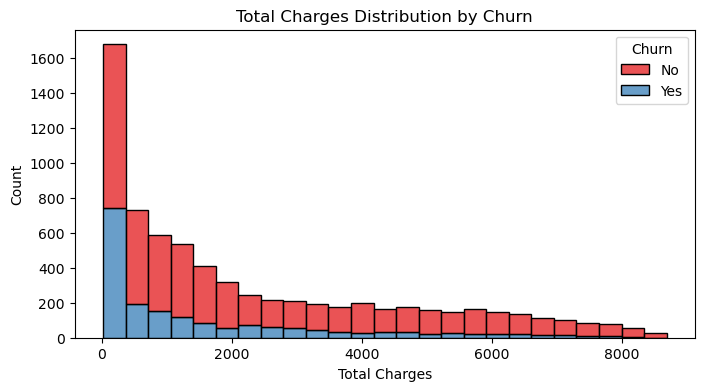

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='TotalCharges', hue='Churn', multiple='stack', palette='Set1')
plt.title('Total Charges Distribution by Churn')
plt.xlabel('Total Charges')
plt.ylabel('Count')
plt.show();

## **DATA PREPROCESSING**

#### **Encoding Categorical Features**

In [19]:
# Encode target vector

df["Churn"] = df["Churn"].map({"Yes":1, "No":0})

In [20]:
# Map features with binary "Yes/No" input

binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]

for col in binary_cols:
    df[col] = df[col].map({"Yes":1, "No":0})

In [21]:
# Merging "No internet service" categories in features below with the "No" category to reduce dimensionality
# They are also both logically equivalent eg If you don’t even subscribe to InternetService, then “Do you have OnlineSecurity?” is effectively a “No.”

internet_cols = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]

for col in internet_cols:
    df[col] = df[col].replace({"No internet service":"No"})
    df[col] = df[col].map({"Yes":1, "No":0})

In [22]:
# Merging "No phone service" in the feature "MultipleLines" with the "No" category

df["MultipleLines"] = df["MultipleLines"].replace({"No phone service":"No"})
df["MultipleLines"] = df["MultipleLines"].map({"Yes":1, "No":0})

#### **Define Target Vector and Feature Matrix**

In [23]:
# Define target vector (y) and feature matrix (X)

X = df.drop(columns=["Churn"])
y = df["Churn"]

# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
# The remaining categorical features/columns

categorical_cols = ["gender","InternetService","Contract","PaymentMethod"]

# Create preprocessor for the pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

## **MODELLING**

#### **Logistic Regression Model (Baseline Model)**

In [35]:
# Define Cross-Validation and scoring metrics

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['roc_auc','precision','recall','f1', 'accuracy']

In [36]:
# Create pipeline for Logistic Regression

lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000))
])

lr_cv_scores = cross_validate(lr_pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Display mean and std of each metric

lr_cv_results = {m: (lr_cv_scores[f'test_{m}'].mean(), lr_cv_scores[f'test_{m}'].std()) for m in scoring}
print("=== Logistic Regression CV Performance ===")
for metric, (mean, std) in lr_cv_results.items():
    print(f"{metric}: {mean:.3f} ± {std:.3f}")

=== Logistic Regression CV Performance ===
roc_auc: 0.838 ± 0.007
precision: 0.512 ± 0.008
recall: 0.814 ± 0.014
f1: 0.629 ± 0.009
accuracy: 0.745 ± 0.007


In [37]:
# Test Set Evaluation

# Fit model
lr_pipeline.fit(X_train, y_train)

# Predict
lr_pred = lr_pipeline.predict(X_test)
lr_proba = lr_pipeline.predict_proba(X_test)[:,1]

print("\n=== Test Performance: Logistic Regression ===")
print(f"ROC AUC : {roc_auc_score(y_test, lr_proba):.3f}")
print(f"Precision: {precision_score(y_test, lr_pred):.3f}")
print(f"Recall   : {recall_score(y_test, lr_pred):.3f}")
print(f"F1 Score : {f1_score(y_test, lr_pred):.3f}")
print(f"Accuracy : {accuracy_score(y_test, lr_pred):.3f}")
print("\nClassification Report:\n", classification_report(y_test, lr_pred, target_names=['No Churn', 'Churn']))


=== Test Performance: Logistic Regression ===
ROC AUC : 0.832
Precision: 0.479
Recall   : 0.802
F1 Score : 0.600
Accuracy : 0.716

Classification Report:
               precision    recall  f1-score   support

    No Churn       0.91      0.68      0.78      1033
       Churn       0.48      0.80      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.73      1407



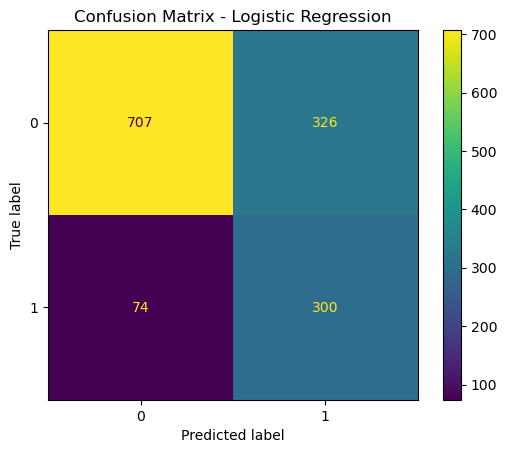

In [38]:
# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, lr_pred)
cm_logreg_display = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=lr_pipeline.classes_)
cm_logreg_display.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show();

#### **XGBoost Classifier Model**

In [39]:
# Estimate scale_pos_weight

# Calculate the scale_pos_weight (negative:positive ratio)
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 2.76


In [40]:
# Build Pipeline

xgb_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier(use_label_encoder=False,
                                 eval_metric='logloss',
                                 random_state=42,
                                 scale_pos_weight=scale_pos_weight))])


xgb_cv = cross_validate(xgb_pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Display mean and std of each metric
xgb_results = {m: (xgb_cv[f'test_{m}'].mean(), xgb_cv[f'test_{m}'].std()) for m in scoring}
print("=== XGBoost CV Performance ===")
for metric, (mean, std) in xgb_results.items():
    print(f"{metric}: {mean:.3f} ± {std:.3f}")

/home/muruthi/anaconda3/envs/learn-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muruthi/anaconda3/envs/learn-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muruthi/anaconda3/envs/learn-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muruthi/anaconda3/envs/learn-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muruthi/anaconda3/envs/learn-env/l

=== XGBoost CV Performance ===
roc_auc: 0.822 ± 0.010
precision: 0.481 ± 0.009
recall: 0.801 ± 0.017
f1: 0.601 ± 0.010
accuracy: 0.717 ± 0.008


In [41]:
# Test set evaluation

xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)
xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Test Performance: XGBoost ===")
print(f"ROC AUC : {roc_auc_score(y_test, xgb_proba):.3f}")
print(f"Precision: {precision_score(y_test, xgb_pred):.3f}")
print(f"Recall   : {recall_score(y_test, xgb_pred):.3f}")
print(f"F1 Score : {f1_score(y_test, xgb_pred):.3f}")
print(f"Accuracy : {accuracy_score(y_test, xgb_pred):.3f}")
print("\nClassification Report:\n", classification_report(y_test, xgb_pred, target_names=['No Churn', 'Churn']))



=== Test Performance: XGBoost ===
ROC AUC : 0.806
Precision: 0.454
Recall   : 0.802
F1 Score : 0.580
Accuracy : 0.691

Classification Report:
               precision    recall  f1-score   support

    No Churn       0.90      0.65      0.76      1033
       Churn       0.45      0.80      0.58       374

    accuracy                           0.69      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.78      0.69      0.71      1407



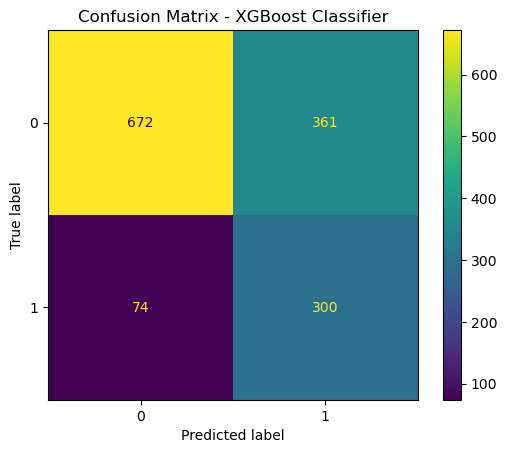

In [42]:
# Confusion Matrix for XGBoost Classifier
cm_xgb = confusion_matrix(y_test, xgb_pred)
cm_xgb_display = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_pipeline.classes_)
cm_xgb_display.plot()
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show();

#### **Random Forest Model**

In [44]:
# Build Pipeline
rf_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced", # Handle Imbalance
        n_jobs=-1))])

rf_cv = cross_validate(rf_pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Display mean and std of each metric
rf_results = {m: (rf_cv[f'test_{m}'].mean(), rf_cv[f'test_{m}'].std()) for m in scoring}
print("=== Random Forest CV Performance ===")
for metric, (mean, std) in rf_results.items():
    print(f"{metric}: {mean:.3f} ± {std:.3f}")

=== Random Forest CV Performance ===
roc_auc: 0.807 ± 0.015
precision: 0.534 ± 0.023
recall: 0.619 ± 0.039
f1: 0.573 ± 0.029
accuracy: 0.756 ± 0.014


In [45]:
# Test set evaluation

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Test Performance: Random Forest ===")
print(f"ROC AUC : {roc_auc_score(y_test, y_proba_rf):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_rf):.3f}")
print(f"F1 Score : {f1_score(y_test, y_pred_rf):.3f}")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))



=== Test Performance: Random Forest ===
ROC AUC : 0.788
Precision: 0.507
Recall   : 0.591
F1 Score : 0.546
Accuracy : 0.738

Classification Report:
               precision    recall  f1-score   support

    No Churn       0.84      0.79      0.82      1033
       Churn       0.51      0.59      0.55       374

    accuracy                           0.74      1407
   macro avg       0.67      0.69      0.68      1407
weighted avg       0.75      0.74      0.74      1407



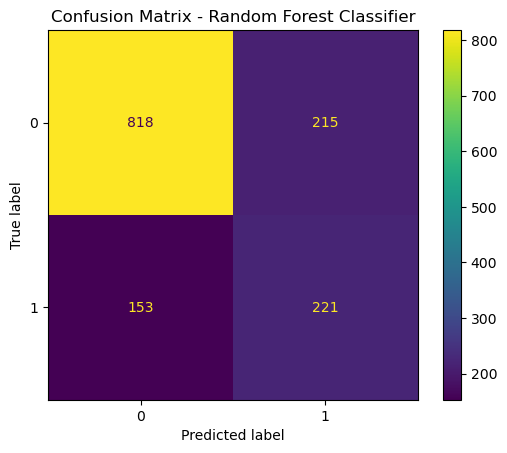

In [47]:
# Confusion Matrix for Random Forest Classifier
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_display = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_pipeline.classes_)
cm_rf_display.plot()
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show();